# Using Callbacks

Callbacks are an integral part of Keras. Callbacks are used to get performance information, log progress, halt in the event of errors, tune parameters, save model state (in case of crash, etc.), finish training once loss is minimized. The list goes on.
Callbacks can be passed to fit, evaluate and predict methods of keras.Model. 

## Goals

The overarching goal is to learn to use callbacks for some typical tasks. These include:
- Reporting about training progress.
- Stoping once training no longer reduces loss.
- Tuning hyperparameters.
- Implementing adaptive learning rate decay.
- Finding an optimal batch-size for training.
- Putting some of this into ```my_keras_utils.py``` so that they can be easily called and reused.

## What's Here?

I continue working with MNIST data, which I began working with in [my first Keras models](first_model.ipynb). 

My **concrete objective** is to tune a model that does well on Kaggle: 97th percentile? That's tough, but I think I can make it work.

In [5]:
import numpy as np
from datetime import datetime, time, timedelta

import pandas as pd
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

import my_keras_utils as my_utils

In [6]:
## Load our data.
## Since the load process is a little slow, the try-except allows us to re-run all 
## cells without having to wait. 
try:
    ## Raises NameError and loads data if X_train is not defined.
    X_train.shape
except NameError: 
    ((X_train, y_train), (X_dev, y_dev), (X_test, y_test)) = my_utils.load_kaggle_mnist()
X_train.shape




(38000, 784)

In [7]:
## Let's use the dropout model from my first_model notebook.

inputs = keras.Input(shape=(784))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Dropout(rate = .05)(x)
x = layers.Dense(100, activation='relu',)(x)
x = layers.Dropout(rate = .15)(x)
x = layers.Dense(100, activation='relu',)(x)
x = layers.Dropout(rate = .15)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_dropout = keras.Model(inputs=inputs, outputs=outputs, name='Dropout')
model_dropout.summary()
optimizer = keras.optimizers.Adam(.001)

model_dropout.compile(optimizer=optimizer, 
                loss="sparse_categorical_crossentropy",
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
            )
init_weights = model_dropout.get_weights()


Model: "Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
rescaling (Rescaling)        (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0   

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience = 10, 
                                                restore_best_weights = True)
progress_update = my_utils.TimedProgressUpdate(.1)
callbacks = [progress_update, early_stopping]
epochs = 0
initial_epoch = 0
batch_size = 128

In [5]:
if False: ## reinitialize
    model_dropout.set_weights(init_weights)    
increment_epochs = 5
epochs += increment_epochs

history = model_dropout.fit(X_train, y_train, 
                        epochs=epochs,
                        initial_epoch = initial_epoch,
                        batch_size=batch_size, 
                        validation_data=(X_dev, y_dev),
                        callbacks = callbacks,
                        verbose = 1)
initial_epoch += increment_epochs

Begin training of Dropout at 20:32:57. Progress updates every 6.0 seconds.
Epoch 1/5
1188/1188 [==============================] - 5s 4ms/step - loss: 0.2845 - acc: 0.9164 - val_loss: 0.1546 - val_acc: 0.9495
Epoch 2/5
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1188 - acc: 0.9636 - val_loss: 0.1279 - val_acc: 0.9565
Epoch 3/5
1188/1188 [==============================] - 5s 4ms/step - loss: 0.0857 - acc: 0.9731 - val_loss: 0.1375 - val_acc: 0.9555
Epoch 4/5
1188/1188 [==============================] - 5s 4ms/step - loss: 0.0619 - acc: 0.9808 - val_loss: 0.1268 - val_acc: 0.9635
Epoch 5/5
1188/1188 [==============================] - 5s 4ms/step - loss: 0.0489 - acc: 0.9846 - val_loss: 0.1207 - val_acc: 0.9660
Finished fitting at 20:33:24. Elapsed time 0:00:26.738193.


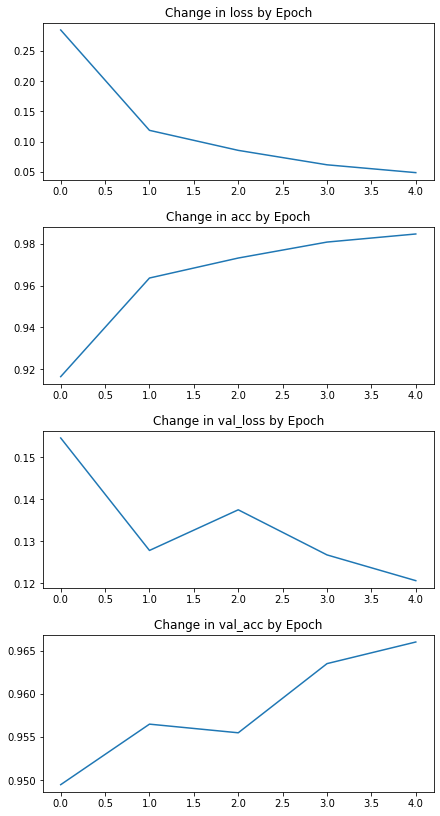

In [6]:
my_utils.history_plot(history, start_epoch=0, end_epoch=None)


#### Read the Docs

Reading the documentation was really helpful. Note that the search function _will_ use callbacks. So, instead of worrying about 
the ```max_epochs```, you can (if you have the resources and time--which _is_ a resource) just add a realistic ```EarlyStopping``` callback. 

In [9]:
def model_builder(hp):
    ## Define the parameter search space.

    hp_dropout_x1 = hp.Choice('rate1', values = [0., .05, .15, .4])
    hp_dropout_w1 = hp.Choice('rate2', values = [.05, .15, .4])
    hp_dropout_w2 = hp.Choice('rate3', values = [.05, .14, .4])

    ## ### I need to learn about the options here. 'Choice' means "here are your choices"
    ## ### 'Int' is a different option that searches an integer range by steps.

    inputs = keras.Input(shape=(784))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.Dropout(rate = hp_dropout_x1)(x)
    x = layers.Dense(100, activation='relu',)(x)
    x = layers.Dropout(rate = hp_dropout_w1)(x)
    x = layers.Dense(100, activation='relu',)(x)
    x = layers.Dropout(rate = hp_dropout_w2)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs=inputs,outputs=outputs)

    model.compile(optimizer = keras.optimizers.Adam(.001),
                    loss = "sparse_categorical_crossentropy",
                    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

    return model

	


In [22]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 200,
                     hyperband_iterations = 10,
                     factor = 3,
                     directory = 'ignored/kt_trials',
                     project_name = 'dropout_mnist')	

tuner.search_space_summary()

In [3]:
## prevent bloated ipython output during training.
clear_output = my_utils.ClearTrainingOutput()
## stop when training loss is not happening.
train_loss_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience = 10, 
                                                restore_best_weights = False
                                                )

tuner_callbacks = [clear_output, train_loss_stopping]


In [20]:
start = datetime.now()
tuner.search(X_train, y_train, 
            epochs=200,
            batch_size=64, 
            validation_data=(X_dev, y_dev),
            callbacks = tuner_callbacks,
            )


INFO:tensorflow:Oracle triggered exit


In [21]:
end = datetime.now()
print(end - start)
tuner.results_summary()

0:04:21.113614


## I'm skeptical

Thy hypterband model may not be the best here. I have certainly seen that this model trains slowly and it's possible that early round victors are getting by on luck. Regularization doesn't become important until dozens or even hundreds of epochs with this model. 

In [10]:
#kt.tuners.RandomSearch?
new_tuner = kt.tuners.RandomSearch(model_builder,
                     objective = 'val_loss', 
                     max_trials = 15,
                     executions_per_trial=2,
                     directory = 'ignored/rand_search_trials',
                     project_name = 'dropout_mnist')
new_tuner.search_space_summary()                    

INFO:tensorflow:Reloading Oracle from existing project ignored/rand_search_trials/dropout_mnist/oracle.json
INFO:tensorflow:Reloading Tuner from ignored/rand_search_trials/dropout_mnist/tuner0.json


In [11]:

new_tuner.search(X_train, y_train, 
            epochs=50,
            batch_size=64, 
            validation_data=(X_dev, y_dev),
            callbacks = tuner_callbacks,
            verbose = 0
            )

INFO:tensorflow:Oracle triggered exit


In [12]:
new_tuner.results_summary()

In [ ]:
best = new_tuner.get_best_models(3)